In [6]:
import torch
import safetensors
from safetensors import safe_open
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Set the GPU device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the file
file_path = "/data/scratch/kaivuh/kronfluencer/influence_results/wikitext/scores_ekfac_pairwise_step2000/pairwise_scores.safetensors"
with safe_open(file_path, framework="pt", device="cuda:2") as f:
    print("Tensor keys:", f.keys())
    
    first_key = list(f.keys())[0]
    adjacency_matrix = f.get_tensor(first_key)
    print(f"\nAdjacency matrix '{first_key}':")
    print("Shape:", adjacency_matrix.shape)
    print("Data type:", adjacency_matrix.dtype)
    print("Device:", adjacency_matrix.device)
    print("First few values:", adjacency_matrix.flatten()[:5])

    # Compute the sum of self weights
    self_weights_sum = torch.trace(adjacency_matrix).item()

    # Convert to numpy array and create graph
    adj_np = adjacency_matrix.cpu().numpy()
    G = nx.from_numpy_array(adj_np)

print(f"\nGraph initialized with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Sum of self weights: {self_weights_sum}")

print(f"\nOriginal graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# # Remove edges below median for each node
# for node in tqdm(G.nodes(), desc="Pruning edges", unit="node"):
#     edges = list(G.edges(node, data=True))
#     if edges:
#         weights = [d['weight'] for _, _, d in edges]
#         median_weight = np.median(weights)
#         edges_to_remove = [(u, v) for u, v, d in edges if d['weight'] < median_weight]
#         G.remove_edges_from(edges_to_remove)

print(f"After pruning: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Using device: cuda:2
Tensor keys: ['all_modules']

Adjacency matrix 'all_modules':
Shape: torch.Size([3686, 3686])
Data type: torch.float32
Device: cuda:2
First few values: tensor([ 1.6022e-01, -1.2614e-04,  1.2916e-03,  3.0043e-04, -4.8524e-05],
       device='cuda:2')

Graph initialized with 3686 nodes and 6795141 edges
Sum of self weights: 853695.0

Original graph: 3686 nodes and 6795141 edges
After pruning: 3686 nodes and 6795141 edges


/tmp/ipykernel_2074573/2161449935.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


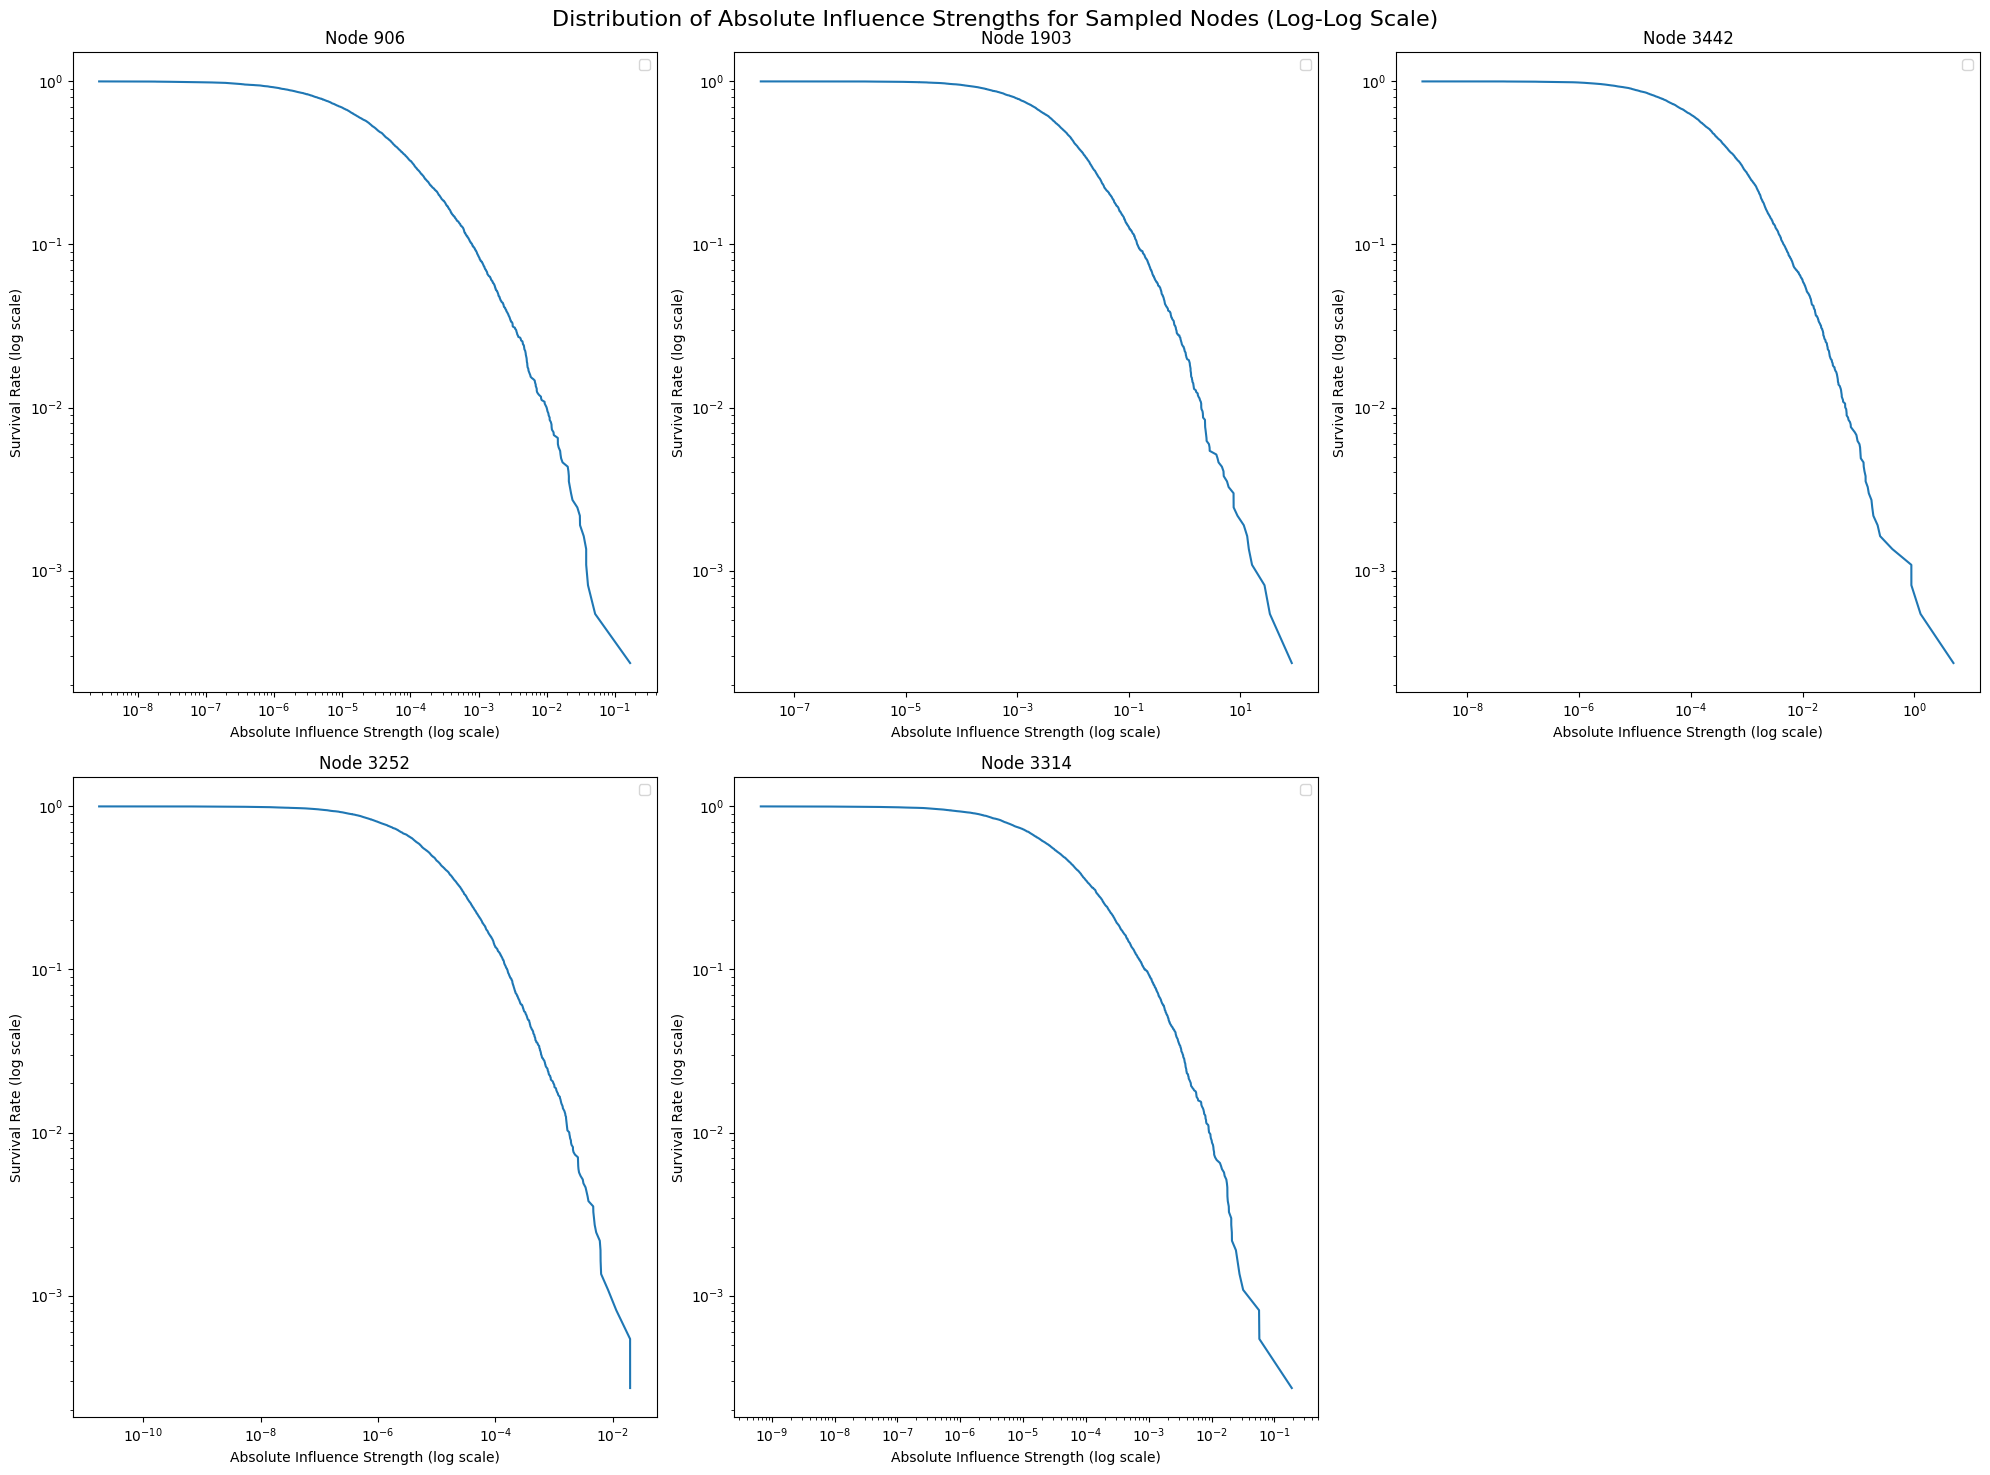


Summary statistics for sampled nodes (absolute values):

Node 906:
  Std Dev: 3.6034e-03
  Min: 2.7155e-09
  Max: 1.6702e-01

Node 1903:
  Std Dev: 1.6835e+00
  Min: 2.4843e-08
  Max: 8.4456e+01

Node 3442:
  Std Dev: 8.8738e-02
  Min: 1.5672e-09
  Max: 5.0127e+00

Node 3252:
  Std Dev: 6.3594e-04
  Min: 1.7842e-11
  Max: 1.9719e-02

Node 3314:
  Std Dev: 3.8428e-03
  Min: 6.7067e-10
  Max: 1.8906e-01


In [7]:
# Sample nodes and plot influence distributions
sampled_nodes = random.sample(list(G.nodes()), 5)

fig, axs = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle("Distribution of Absolute Influence Strengths for Sampled Nodes (Log-Log Scale)", fontsize=16)
axs = axs.flatten()

for i, node in enumerate(sampled_nodes):
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    weights = weights[weights > 0]
    sorted_weights = np.sort(weights)[::-1]
    survival_rate = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)
    
    axs[i].plot(sorted_weights, survival_rate)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_title(f"Node {node}")
    axs[i].set_xlabel("Absolute Influence Strength (log scale)")
    axs[i].set_ylabel("Survival Rate (log scale)")
    
    mean_weight = np.mean(weights)
    median_weight = np.median(weights)
    # axs[i].axvline(mean_weight, color='r', linestyle='dashed', linewidth=2, label=f'Mean ({mean_weight:.2e})')
    # axs[i].axvline(median_weight, color='g', linestyle='dashed', linewidth=2, label=f'Median ({median_weight:.2e})')
    axs[i].legend()

axs[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nSummary statistics for sampled nodes (absolute values):")
for node in sampled_nodes:
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    weights = weights[weights > 0]
    print(f"\nNode {node}:")
    # print(f"  Mean: {np.mean(weights):.4e}")
    # print(f"  Median: {np.median(weights):.4e}")
    print(f"  Std Dev: {np.std(weights):.4e}")
    print(f"  Min: {np.min(weights):.4e}")
    print(f"  Max: {np.max(weights):.4e}")

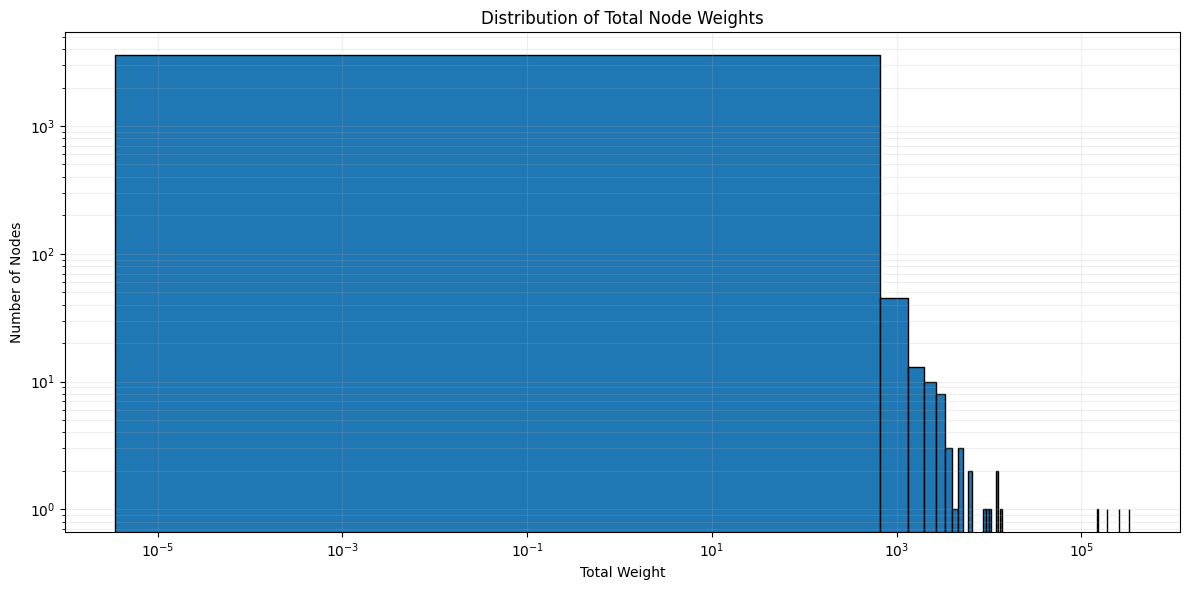


Summary statistics for total node weights:
Mean: 3.411853e+02
Median: 5.954702e+00
Std Dev: 7.936691e+03
Min: 3.486627e-06
Max: 3.293823e+05

Top 10 nodes by total weight:
Node 2427: 3.293823e+05
Node 1471: 2.534804e+05
Node 1966: 1.910295e+05
Node 2039: 1.490283e+05
Node 322: 1.332112e+04
Node 3020: 1.203672e+04
Node 2986: 1.187649e+04
Node 805: 1.031322e+04
Node 1391: 9.309921e+03
Node 2636: 8.783699e+03


In [5]:
# Compute total weight for each node
total_weights = {}
for node in G.nodes():
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    total_weights[node] = np.sum(weights)

# Plot the distribution of total weights
plt.figure(figsize=(12, 6))
plt.hist(list(total_weights.values()), bins=500, edgecolor='black')
plt.title("Distribution of Total Node Weights")
plt.xlabel("Total Weight")
plt.ylabel("Number of Nodes")
plt.yscale('log')  # Use log scale for y-axis to better visualize the distribution
plt.xscale('log')  # Use log scale for x-axis as well
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

# Print summary statistics
weights = np.array(list(total_weights.values()))
print("\nSummary statistics for total node weights:")
print(f"Mean: {np.mean(weights):.6e}")
print(f"Median: {np.median(weights):.6e}")
print(f"Std Dev: {np.std(weights):.6e}")
print(f"Min: {np.min(weights):.6e}")
print(f"Max: {np.max(weights):.6e}")

# Identify top 10 nodes by total weight
top_nodes = sorted(total_weights.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by total weight:")
for node, weight in top_nodes:
    print(f"Node {node}: {weight:.6e}")

In [3]:
# Get and sort the largest diagonal values from the original safetensors file
with safe_open(file_path, framework="pt", device="cuda:2") as f:
    first_key = list(f.keys())[0]
    adjacency_matrix = f.get_tensor(first_key)
    diagonal_values = adjacency_matrix.diag()
    
    # Get the top 10 diagonal values and their indices
    top_values, top_indices = torch.topk(diagonal_values, k=10)
    
    print("Top 10 diagonal values with their indices:")
    for i, (value, index) in enumerate(zip(top_values, top_indices), 1):
        print(f"{i}. Index: {index.item()}, Value: {value.item():.6e}")

Top 10 diagonal values with their indices:
1. Index: 2427, Value: 2.699164e+05
2. Index: 1471, Value: 1.896784e+05
3. Index: 1966, Value: 1.668758e+05
4. Index: 2039, Value: 1.012844e+05
5. Index: 322, Value: 9.391151e+03
6. Index: 3020, Value: 9.343374e+03
7. Index: 2986, Value: 8.974867e+03
8. Index: 805, Value: 7.375920e+03
9. Index: 400, Value: 3.774717e+03
10. Index: 99, Value: 3.715839e+03

Diagonal value for node 1046: 3.485574e-03
